In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import tensorflow as tf
import GPflow
import time
import loogp
reload(loogp)
import gpitch as gpi

In [2]:
plt.rcParams['figure.figsize'] = (18, 6)  # set plot size
plt.interactive(True)
plt.close('all')

In [3]:
# generate synthetic data
fs = 16e3  # sample frequency
N = 1600  # number of samples
x = np.linspace(0, (N-1.)/fs, N).reshape(-1, 1)  # time
noise_var = 1.e-3
pitch1 = 440.00  # Hertz, A4 (La)
pitch2 = 659.25  # Hertz, E5 (Mi)
kenv1 = GPflow.kernels.Matern32(input_dim=1, lengthscales=0.01, variance=10.)
kenv2 = GPflow.kernels.Matern32(input_dim=1, lengthscales=0.005, variance=10.)
kper1 = GPflow.kernels.PeriodicKernel(input_dim=1, lengthscales=0.25,
                                      variance=np.sqrt(0.5), period=1./pitch1)
kper2 = GPflow.kernels.PeriodicKernel(input_dim=1, lengthscales=0.25,
                                      variance=np.sqrt(0.5), period=1./pitch2)

Kenv1 = kenv1.compute_K_symm(x)
Kenv2 = kenv2.compute_K_symm(x)
Kper1 = kper1.compute_K_symm(x)
Kper2 = kper2.compute_K_symm(x)

In [4]:
np.random.seed(29)
f1 = np.random.multivariate_normal(np.zeros(x.shape[0]), Kper1).reshape(-1, 1)
f2 = np.random.multivariate_normal(np.zeros(x.shape[0]), Kper2).reshape(-1, 1)
f1 /= np.max(np.abs(f1))
f2 /= np.max(np.abs(f2))
g1 = np.random.multivariate_normal(np.zeros(x.shape[0]), Kenv1).reshape(-1, 1)
g2 = np.random.multivariate_normal(np.zeros(x.shape[0]), Kenv2).reshape(-1, 1)
source1 = gpi.logistic(g1)*f1
source2 = gpi.logistic(g2)*f2
mean = source1 + source2
y = mean + np.random.randn(*mean.shape) * np.sqrt(noise_var)

In [5]:
# split data into windows
ws = 400  # window size (samples)
#ws = N  # use all data at once (i.e. no windowing)
Nw = N/ws  # number of windows
x_l = [x[i*ws:(i+1)*ws].copy() for i in range(0, Nw)]
y_l = [y[i*ws:(i+1)*ws].copy() for i in range(0, Nw)]

# Results using new code version 

In [6]:
jump = 30  # initialize model
z = x_l[0][::jump].copy()
m = loogp.LooGP(x_l[0].copy(), y_l[0].copy(), [kper1, kper2], [kenv1, kenv2], z,
                whiten=True)
m.likelihood.noise_var = noise_var
m.likelihood.noise_var.fixed = True
m.kern_f1.fixed = True
m.kern_f2.fixed = True
m.kern_g1.fixed = True
m.kern_g2.fixed = True

In [7]:
qm1 = [np.zeros(z.shape) for i in range(0, Nw)]  # list to save predictions
qm2 = [np.zeros(z.shape) for i in range(0, Nw)]  # mean (qm) and variance (qv)
qm3 = [np.zeros(z.shape) for i in range(0, Nw)]
qm4 = [np.zeros(z.shape) for i in range(0, Nw)]
qv1 = [np.zeros(z.shape) for i in range(0, Nw)]
qv2 = [np.zeros(z.shape) for i in range(0, Nw)]
qv3 = [np.zeros(z.shape) for i in range(0, Nw)]
qv4 = [np.zeros(z.shape) for i in range(0, Nw)]

maxiter = 250
start_time = time.time()
for i in range(Nw):
    m.X = x_l[i].copy()
    m.Y = y_l[i].copy()
    m.Z = x_l[i][::jump].copy()

    m.q_mu1._array = np.zeros(z.shape)
    m.q_mu2._array = np.zeros(z.shape)
    m.q_mu3._array = np.zeros(z.shape)
    m.q_mu4._array = np.zeros(z.shape)
    m.q_sqrt1._array = np.expand_dims(np.eye(z.size), 2)
    m.q_sqrt2._array = np.expand_dims(np.eye(z.size), 2)
    m.q_sqrt3._array = np.expand_dims(np.eye(z.size), 2)
    m.q_sqrt4._array = np.expand_dims(np.eye(z.size), 2)

    m.optimize(disp=1, maxiter=maxiter)
    qm1[i], qv1[i] = m.predict_f1(x_l[i])
    qm2[i], qv2[i] = m.predict_g1(x_l[i])
    qm3[i], qv3[i] = m.predict_f2(x_l[i])
    qm4[i], qv4[i] = m.predict_g2(x_l[i])

print("--- %s seconds ---" % (time.time() - start_time))

qm1 = np.asarray(qm1).reshape(-1, 1)
qm2 = np.asarray(qm2).reshape(-1, 1)
qm3 = np.asarray(qm3).reshape(-1, 1)
qm4 = np.asarray(qm4).reshape(-1, 1)
qv1 = np.asarray(qv1).reshape(-1, 1)
qv2 = np.asarray(qv2).reshape(-1, 1)
qv3 = np.asarray(qv3).reshape(-1, 1)
qv4 = np.asarray(qv4).reshape(-1, 1)

--- 10.0269281864 seconds ---


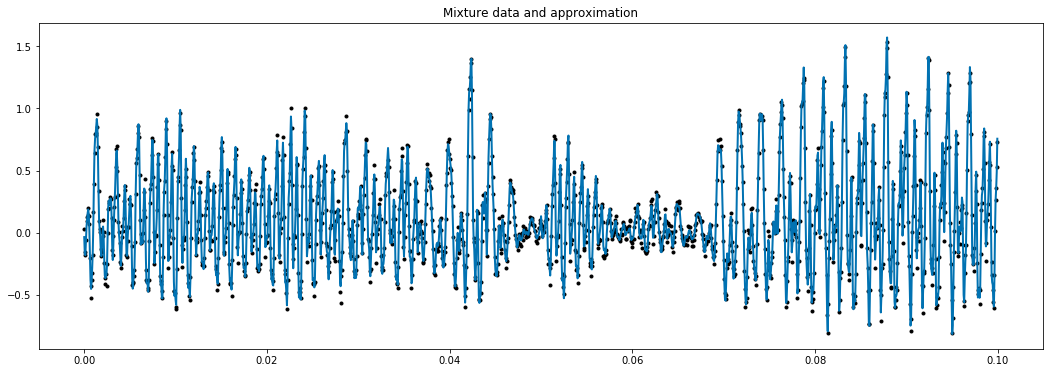

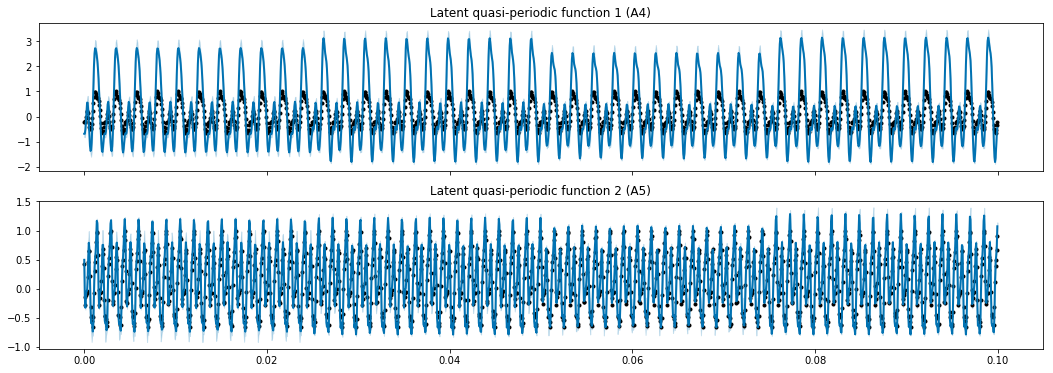

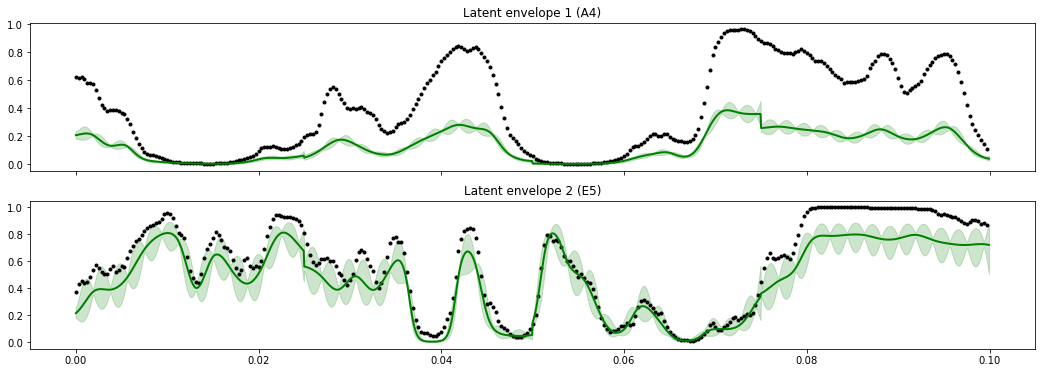

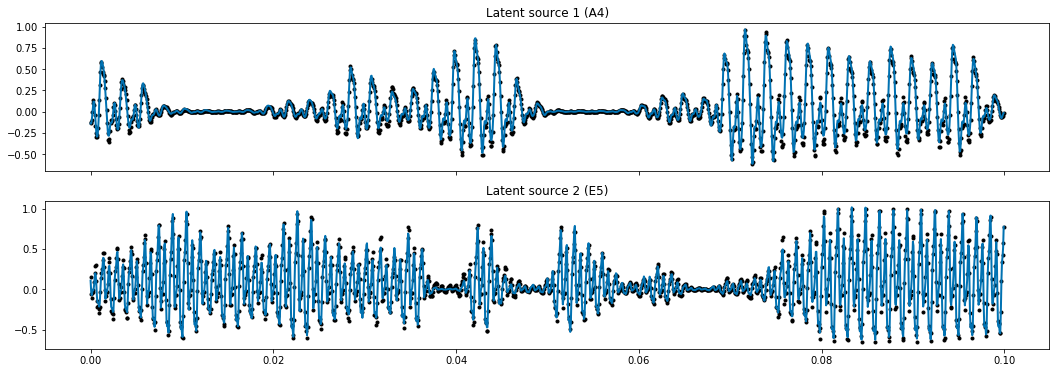

In [8]:
yhat = gpi.logistic(qm2)*qm1 + gpi.logistic(qm4)*qm3

col = '#0172B2'
plt.figure(), plt.title('Mixture data and approximation')
plt.plot(x, y, '.k', mew=1)
plt.plot(x, yhat, color=col , lw=2)

f, axarr = plt.subplots(2, sharex=True)
axarr[0].set_title('Latent quasi-periodic function 1 (A4)')
axarr[0].plot(x, f1, '.k', mew=1)
axarr[0].plot(x, qm1, color=col, lw=2)
axarr[0].fill_between(x[:, 0], qm1[:, 0] - 2*np.sqrt(qv1[:, 0]),
                 qm1[:, 0] + 2*np.sqrt(qv1[:, 0]),
                 color=col, alpha=0.2)
axarr[1].set_title('Latent quasi-periodic function 2 (A5)')
axarr[1].plot(x, f2, '.k', mew=1)
axarr[1].plot(x, qm3, color=col, lw=2)
axarr[1].fill_between(x[:, 0], qm3[:, 0] - 2*np.sqrt(qv3[:, 0]),
                 qm3[:, 0] + 2*np.sqrt(qv3[:, 0]),
                 color=col, alpha=0.2)

f, axarr = plt.subplots(2, sharex=True)
axarr[0].set_title('Latent envelope 1 (A4)')
axarr[0].plot(x[::5], gpi.logistic(g1[::5]), '.k', mew=1)
axarr[0].plot(x, gpi.logistic(qm2), 'g', lw=2)
axarr[0].fill_between(x[:, 0], gpi.logistic(qm2[:, 0] - 2*np.sqrt(qv2[:, 0])),
                  gpi.logistic(qm2[:, 0] + 2*np.sqrt(qv2[:, 0])),
                  color='green', alpha=0.2)
axarr[1].set_title('Latent envelope 2 (E5)')
axarr[1].plot(x[::5], gpi.logistic(g2[::5]), '.k', mew=1)
axarr[1].plot(x, gpi.logistic(qm4), 'g', lw=2)
axarr[1].fill_between(x[:, 0], gpi.logistic(qm4[:, 0] - 2*np.sqrt(qv4[:, 0])),
                  gpi.logistic(qm4[:, 0] + 2*np.sqrt(qv4[:, 0])),
                  color='green', alpha=0.2)

f, axarr = plt.subplots(2, sharex=True)
axarr[0].set_title('Latent source 1 (A4)')
axarr[0].plot(x, source1, '.k', mew=1)
axarr[0].plot(x, gpi.logistic(qm2)*qm1, color=col, lw=2)
axarr[1].set_title('Latent source 2 (E5)')
axarr[1].plot(x, source2, '.k')
axarr[1].plot(x, gpi.logistic(qm4)*qm3, color=col, lw=2)

# Results using old code version

In [9]:
z = x_l[0][::jump].copy()
m2 = loogp.LooGP(x_l[0].copy(), y_l[0].copy(), [kper1, kper2], [kenv1, kenv2], z, whiten=True, old_version=True)
m2.likelihood.noise_var = noise_var
m2.likelihood.noise_var.fixed = True
m2.kern_f1.fixed = True
m2.kern_f2.fixed = True
m2.kern_g1.fixed = True
m2.kern_g2.fixed = True

In [10]:
qm1 = [np.zeros(z.shape) for i in range(0, Nw)]  # list to save predictions
qm2 = [np.zeros(z.shape) for i in range(0, Nw)]  # mean (qm) and variance (qv)
qm3 = [np.zeros(z.shape) for i in range(0, Nw)]
qm4 = [np.zeros(z.shape) for i in range(0, Nw)]
qv1 = [np.zeros(z.shape) for i in range(0, Nw)]
qv2 = [np.zeros(z.shape) for i in range(0, Nw)]
qv3 = [np.zeros(z.shape) for i in range(0, Nw)]
qv4 = [np.zeros(z.shape) for i in range(0, Nw)]

start_time = time.time()
for i in range(Nw):
    m2.X = x_l[i].copy()
    m2.Y = y_l[i].copy()
    m2.Z = x_l[i][::jump].copy()

    m2.q_mu1._array = np.zeros(z.shape)
    m2.q_mu2._array = np.zeros(z.shape)
    m2.q_mu3._array = np.zeros(z.shape)
    m2.q_mu4._array = np.zeros(z.shape)
    m2.q_sqrt1._array = np.expand_dims(np.eye(z.size), 2)
    m2.q_sqrt2._array = np.expand_dims(np.eye(z.size), 2)
    m2.q_sqrt3._array = np.expand_dims(np.eye(z.size), 2)
    m2.q_sqrt4._array = np.expand_dims(np.eye(z.size), 2)

    m2.optimize(disp=1, maxiter=maxiter)
    qm1[i], qv1[i] = m2.predict_f1(x_l[i])
    qm2[i], qv2[i] = m2.predict_g1(x_l[i])
    qm3[i], qv3[i] = m2.predict_f2(x_l[i])
    qm4[i], qv4[i] = m2.predict_g2(x_l[i])

print("--- %s seconds ---" % (time.time() - start_time))

qm1 = np.asarray(qm1).reshape(-1, 1)
qm2 = np.asarray(qm2).reshape(-1, 1)
qm3 = np.asarray(qm3).reshape(-1, 1)
qm4 = np.asarray(qm4).reshape(-1, 1)
qv1 = np.asarray(qv1).reshape(-1, 1)
qv2 = np.asarray(qv2).reshape(-1, 1)
qv3 = np.asarray(qv3).reshape(-1, 1)
qv4 = np.asarray(qv4).reshape(-1, 1)

--- 85.1259479523 seconds ---


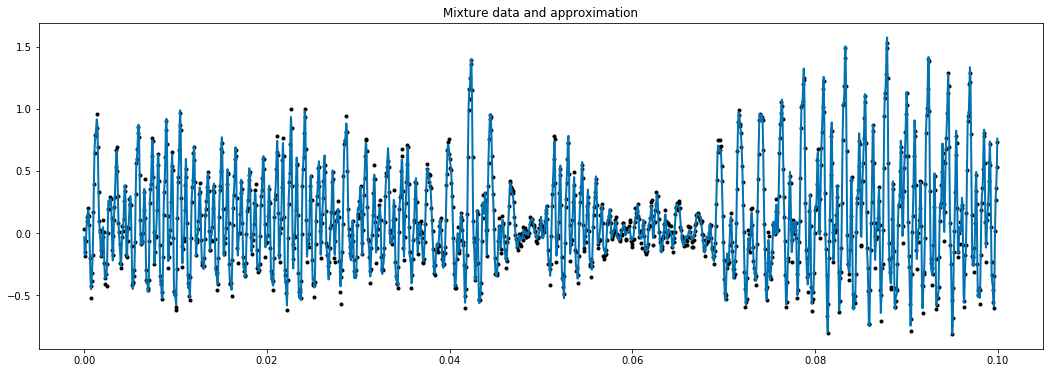

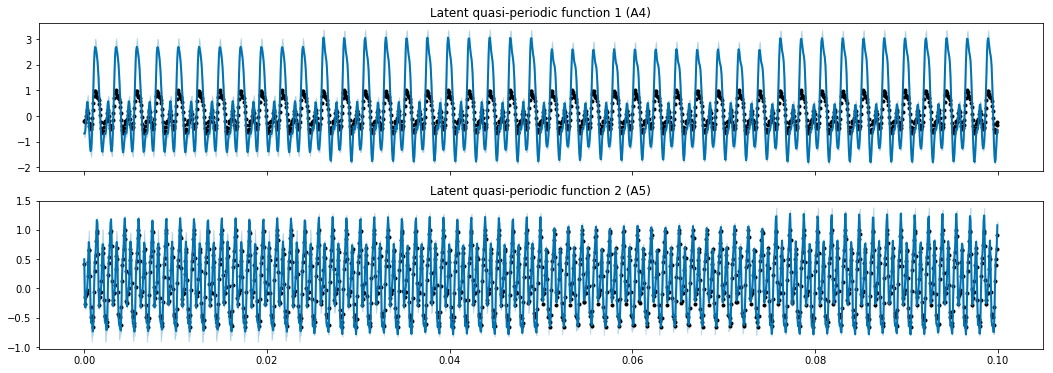

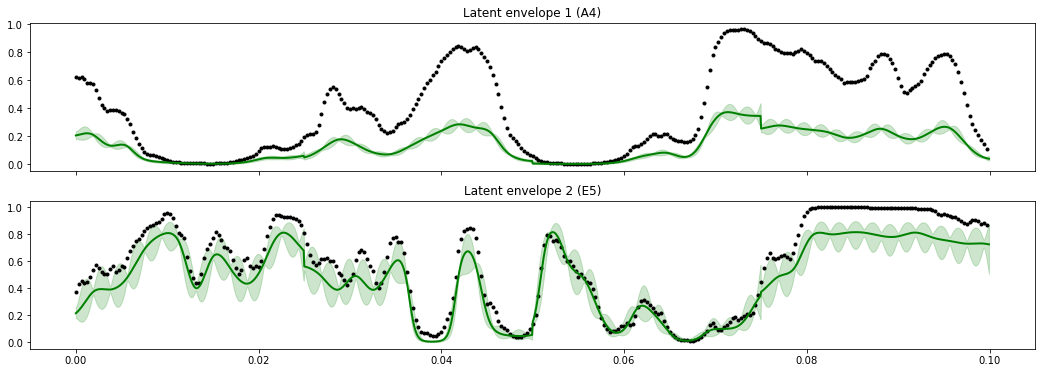

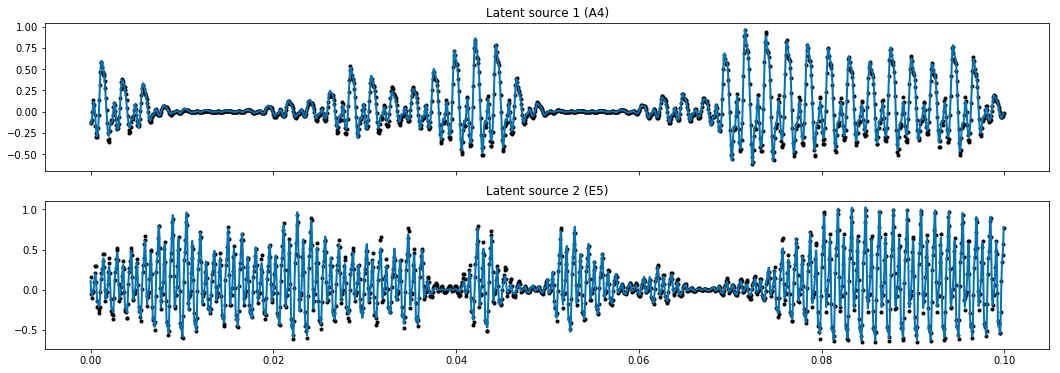

In [11]:
yhat = gpi.logistic(qm2)*qm1 + gpi.logistic(qm4)*qm3

col = '#0172B2'
plt.figure(), plt.title('Mixture data and approximation')
plt.plot(x, y, '.k', mew=1)
plt.plot(x, yhat, color=col , lw=2)

f, axarr = plt.subplots(2, sharex=True)
axarr[0].set_title('Latent quasi-periodic function 1 (A4)')
axarr[0].plot(x, f1, '.k', mew=1)
axarr[0].plot(x, qm1, color=col, lw=2)
axarr[0].fill_between(x[:, 0], qm1[:, 0] - 2*np.sqrt(qv1[:, 0]),
                 qm1[:, 0] + 2*np.sqrt(qv1[:, 0]),
                 color=col, alpha=0.2)
axarr[1].set_title('Latent quasi-periodic function 2 (A5)')
axarr[1].plot(x, f2, '.k', mew=1)
axarr[1].plot(x, qm3, color=col, lw=2)
axarr[1].fill_between(x[:, 0], qm3[:, 0] - 2*np.sqrt(qv3[:, 0]),
                 qm3[:, 0] + 2*np.sqrt(qv3[:, 0]),
                 color=col, alpha=0.2)

f, axarr = plt.subplots(2, sharex=True)
axarr[0].set_title('Latent envelope 1 (A4)')
axarr[0].plot(x[::5], gpi.logistic(g1[::5]), '.k', mew=1)
axarr[0].plot(x, gpi.logistic(qm2), 'g', lw=2)
axarr[0].fill_between(x[:, 0], gpi.logistic(qm2[:, 0] - 2*np.sqrt(qv2[:, 0])),
                  gpi.logistic(qm2[:, 0] + 2*np.sqrt(qv2[:, 0])),
                  color='green', alpha=0.2)
axarr[1].set_title('Latent envelope 2 (E5)')
axarr[1].plot(x[::5], gpi.logistic(g2[::5]), '.k', mew=1)
axarr[1].plot(x, gpi.logistic(qm4), 'g', lw=2)
axarr[1].fill_between(x[:, 0], gpi.logistic(qm4[:, 0] - 2*np.sqrt(qv4[:, 0])),
                  gpi.logistic(qm4[:, 0] + 2*np.sqrt(qv4[:, 0])),
                  color='green', alpha=0.2)

f, axarr = plt.subplots(2, sharex=True)
axarr[0].set_title('Latent source 1 (A4)')
axarr[0].plot(x, source1, '.k', mew=1)
axarr[0].plot(x, gpi.logistic(qm2)*qm1, color=col, lw=2)
axarr[1].set_title('Latent source 2 (E5)')
axarr[1].plot(x, source2, '.k')
axarr[1].plot(x, gpi.logistic(qm4)*qm3, color=col, lw=2)